# Generates images from text prompts with CLIP guided diffusion.

By Katherine Crowson (https://github.com/crowsonkb, https://twitter.com/RiversHaveWings). It uses a 512x512 unconditional ImageNet diffusion model fine-tuned from OpenAI's 512x512 class-conditional ImageNet diffusion model (https://github.com/openai/guided-diffusion) together with CLIP (https://github.com/openai/CLIP) to connect text prompts with images. It uses a smaller secondary diffusion model trained by Katherine Crowson to remove noise from intermediate timesteps to prepare them for CLIP.

In [1]:
# @title Licensed under the MIT License

# Copyright (c) 2021 Katherine Crowson

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.

In [2]:
# Check the GPU

!nvidia-smi

Tue Jun  7 20:19:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      On   | 00000000:07:00.0 Off |                    0 |
| N/A   25C    P0    57W / 400W |   1920MiB / 40537MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  A100-SXM4-40GB      On   | 00000000:0F:00.0 Off |                    0 |
| N/A   

In [3]:
# Install dependencies

!git clone https://github.com/openai/CLIP
!git clone https://github.com/crowsonkb/guided-diffusion
!pip install -e ./CLIP
!pip install -e ./guided-diffusion
!pip install lpips

Cloning into 'CLIP'...
remote: Enumerating objects: 222, done.
remote: Total 222 (delta 0), reused 0 (delta 0), pack-reused 222
Receiving objects: 100% (222/222), 8.91 MiB | 5.55 MiB/s, done.
Resolving deltas: 100% (113/113), done.
Cloning into 'guided-diffusion'...
remote: Enumerating objects: 102, done.
remote: Total 102 (delta 0), reused 0 (delta 0), pack-reused 102
Receiving objects: 100% (102/102), 70.25 KiB | 1.76 MiB/s, done.
Resolving deltas: 100% (53/53), done.
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Obtaining file:///home/chenweifeng/txt2img_project/notebooks/CLIP
  Attempting uninstall: clip
    Found existing installation: clip 1.0
    Uninstalling clip-1.0:
      Successfully uninstalled clip-1.0
  Running setup.py develop for clip
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Obtaining file:///home/chenweifeng/txt2img_project/notebooks/guided-diffusion
  Running setup.py develop for guided-diffusion
Looking in indexes: https://pypi.tuna

In [4]:
# Download the diffusion model
# SHA-256: 9c111ab89e214862b76e1fa6a1b3f1d329b1a88281885943d2cdbe357ad57648

!curl -OL --http1.1 https://the-eye.eu/public/AI/models/512x512_diffusion_unconditional_ImageNet/512x512_diffusion_uncond_finetune_008100.pt

# Download the secondary diffusion model
# SHA-256: b209c3bfbaeb656140726ce9d6fbf921b030193f96ba160bf13d451982201fb7

!curl -OL --http1.1 https://the-eye.eu/public/AI/models/v-diffusion/secondary_model_imagenet.pth

# Download the secondary diffusion model v2
# SHA-256: 983e3de6f95c88c81b2ca7ebb2c217933be1973b1ff058776b970f901584613a 

!curl -OL --http1.1 https://the-eye.eu/public/AI/models/v-diffusion/secondary_model_imagenet_2.pth

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0 2128M    0 7423k    0     0  12732      0 48:41:48  0:09:57 48:31:51  3512 0 47:25:35  0:06:52 47:18:43  8920
curl: (56) OpenSSL SSL_read: Connection reset by peer, errno 104
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 20.7M  100 20.7M    0     0  3522k      0  0:00:06  0:00:06 --:--:-- 4754k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 52.8M  100 52.8M    0     0   347k      0  0:02:35  0:02:35 --:--:--  306k  0   223k      0  0:04:02  0:00:27  0:03:35  187k03:23  198k    0   215k      0  0:04:11  0:01:06  0:03:05  483k


In [12]:
# Imports

from dataclasses import dataclass
from functools import partial
import gc
import io
import math
import sys

from IPython import display
import lpips
from PIL import Image
import requests
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm

sys.path.append('./CLIP')
sys.path.append('./guided-diffusion')

import clip
from guided_diffusion.script_util import create_model_and_diffusion, model_and_diffusion_defaults

torch.backends.cudnn.enabled = False

In [13]:
# Define necessary functions

def fetch(url_or_path):
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return fd
    return open(url_or_path, 'rb')


def parse_prompt(prompt):
    if prompt.startswith('http://') or prompt.startswith('https://'):
        vals = prompt.rsplit(':', 2)
        vals = [vals[0] + ':' + vals[1], *vals[2:]]
    else:
        vals = prompt.rsplit(':', 1)
    vals = vals + ['', '1'][len(vals):]
    return vals[0], float(vals[1])


class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(F.adaptive_avg_pool2d(cutout, self.cut_size))
        return torch.cat(cutouts)


def spherical_dist_loss(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)


def tv_loss(input):
    """L2 total variation loss, as in Mahendran et al."""
    input = F.pad(input, (0, 1, 0, 1), 'replicate')
    x_diff = input[..., :-1, 1:] - input[..., :-1, :-1]
    y_diff = input[..., 1:, :-1] - input[..., :-1, :-1]
    return (x_diff**2 + y_diff**2).mean([1, 2, 3])


def range_loss(input):
    return (input - input.clamp(-1, 1)).pow(2).mean([1, 2, 3])


In [14]:
# Define the secondary diffusion model

def append_dims(x, n):
    return x[(Ellipsis, *(None,) * (n - x.ndim))]


def expand_to_planes(x, shape):
    return append_dims(x, len(shape)).repeat([1, 1, *shape[2:]])


def alpha_sigma_to_t(alpha, sigma):
    return torch.atan2(sigma, alpha) * 2 / math.pi


def t_to_alpha_sigma(t):
    return torch.cos(t * math.pi / 2), torch.sin(t * math.pi / 2)


@dataclass
class DiffusionOutput:
    v: torch.Tensor
    pred: torch.Tensor
    eps: torch.Tensor


class ConvBlock(nn.Sequential):
    def __init__(self, c_in, c_out):
        super().__init__(
            nn.Conv2d(c_in, c_out, 3, padding=1),
            nn.ReLU(inplace=True),
        )


class SkipBlock(nn.Module):
    def __init__(self, main, skip=None):
        super().__init__()
        self.main = nn.Sequential(*main)
        self.skip = skip if skip else nn.Identity()

    def forward(self, input):
        return torch.cat([self.main(input), self.skip(input)], dim=1)


class FourierFeatures(nn.Module):
    def __init__(self, in_features, out_features, std=1.):
        super().__init__()
        assert out_features % 2 == 0
        self.weight = nn.Parameter(torch.randn([out_features // 2, in_features]) * std)

    def forward(self, input):
        f = 2 * math.pi * input @ self.weight.T
        return torch.cat([f.cos(), f.sin()], dim=-1)


class SecondaryDiffusionImageNet(nn.Module):
    def __init__(self):
        super().__init__()
        c = 64  # The base channel count

        self.timestep_embed = FourierFeatures(1, 16)

        self.net = nn.Sequential(
            ConvBlock(3 + 16, c),
            ConvBlock(c, c),
            SkipBlock([
                nn.AvgPool2d(2),
                ConvBlock(c, c * 2),
                ConvBlock(c * 2, c * 2),
                SkipBlock([
                    nn.AvgPool2d(2),
                    ConvBlock(c * 2, c * 4),
                    ConvBlock(c * 4, c * 4),
                    SkipBlock([
                        nn.AvgPool2d(2),
                        ConvBlock(c * 4, c * 8),
                        ConvBlock(c * 8, c * 4),
                        nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                    ]),
                    ConvBlock(c * 8, c * 4),
                    ConvBlock(c * 4, c * 2),
                    nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                ]),
                ConvBlock(c * 4, c * 2),
                ConvBlock(c * 2, c),
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            ]),
            ConvBlock(c * 2, c),
            nn.Conv2d(c, 3, 3, padding=1),
        )

    def forward(self, input, t):
        timestep_embed = expand_to_planes(self.timestep_embed(t[:, None]), input.shape)
        v = self.net(torch.cat([input, timestep_embed], dim=1))
        alphas, sigmas = map(partial(append_dims, n=v.ndim), t_to_alpha_sigma(t))
        pred = input * alphas - v * sigmas
        eps = input * sigmas + v * alphas
        return DiffusionOutput(v, pred, eps)


class SecondaryDiffusionImageNet2(nn.Module):
    def __init__(self):
        super().__init__()
        c = 64  # The base channel count
        cs = [c, c * 2, c * 2, c * 4, c * 4, c * 8]

        self.timestep_embed = FourierFeatures(1, 16)
        self.down = nn.AvgPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

        self.net = nn.Sequential(
            ConvBlock(3 + 16, cs[0]),
            ConvBlock(cs[0], cs[0]),
            SkipBlock([
                self.down,
                ConvBlock(cs[0], cs[1]),
                ConvBlock(cs[1], cs[1]),
                SkipBlock([
                    self.down,
                    ConvBlock(cs[1], cs[2]),
                    ConvBlock(cs[2], cs[2]),
                    SkipBlock([
                        self.down,
                        ConvBlock(cs[2], cs[3]),
                        ConvBlock(cs[3], cs[3]),
                        SkipBlock([
                            self.down,
                            ConvBlock(cs[3], cs[4]),
                            ConvBlock(cs[4], cs[4]),
                            SkipBlock([
                                self.down,
                                ConvBlock(cs[4], cs[5]),
                                ConvBlock(cs[5], cs[5]),
                                ConvBlock(cs[5], cs[5]),
                                ConvBlock(cs[5], cs[4]),
                                self.up,
                            ]),
                            ConvBlock(cs[4] * 2, cs[4]),
                            ConvBlock(cs[4], cs[3]),
                            self.up,
                        ]),
                        ConvBlock(cs[3] * 2, cs[3]),
                        ConvBlock(cs[3], cs[2]),
                        self.up,
                    ]),
                    ConvBlock(cs[2] * 2, cs[2]),
                    ConvBlock(cs[2], cs[1]),
                    self.up,
                ]),
                ConvBlock(cs[1] * 2, cs[1]),
                ConvBlock(cs[1], cs[0]),
                self.up,
            ]),
            ConvBlock(cs[0] * 2, cs[0]),
            nn.Conv2d(cs[0], 3, 3, padding=1),
        )

    def forward(self, input, t):
        timestep_embed = expand_to_planes(self.timestep_embed(t[:, None]), input.shape)
        v = self.net(torch.cat([input, timestep_embed], dim=1))
        alphas, sigmas = map(partial(append_dims, n=v.ndim), t_to_alpha_sigma(t))
        pred = input * alphas - v * sigmas
        eps = input * sigmas + v * alphas
        return DiffusionOutput(v, pred, eps)


In [15]:
# Model settings

model_config = model_and_diffusion_defaults()
model_config.update({
    'attention_resolutions': '32, 16, 8',
    'class_cond': False,
    'diffusion_steps': 1000,
    'rescale_timesteps': True,
    'timestep_respacing': '500',   # Modify this value to decrease the number of
                                   # timesteps.
    'image_size': 512,
    'learn_sigma': True,
    'noise_schedule': 'linear',
    'num_channels': 256,
    'num_head_channels': 64,
    'num_res_blocks': 2,
    'resblock_updown': True,
    'use_checkpoint': False,
    'use_fp16': True,
    'use_scale_shift_norm': True,
})
method = 'ddpm'  # ddim, ddpm, plms[1-4]
secondary_model_ver = 2

In [16]:
# Load models

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

model, diffusion = create_model_and_diffusion(**model_config)
model.load_state_dict(torch.load('512x512_diffusion_uncond_finetune_008100.pt', map_location='cpu'))
model.requires_grad_(False).eval().to(device)
if model_config['use_fp16']:
    model.convert_to_fp16()

if secondary_model_ver == 1:
    secondary_model = SecondaryDiffusionImageNet()
    secondary_model.load_state_dict(torch.load('secondary_model_imagenet.pth', map_location='cpu'))
elif secondary_model_ver == 2:
    secondary_model = SecondaryDiffusionImageNet2()
    secondary_model.load_state_dict(torch.load('secondary_model_imagenet_2.pth', map_location='cpu'))
secondary_model.eval().requires_grad_(False).to(device)

clip_model = clip.load('ViT-B/16', jit=False)[0].eval().requires_grad_(False).to(device)
clip_size = clip_model.visual.input_resolution
normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                 std=[0.26862954, 0.26130258, 0.27577711])
lpips_model = lpips.LPIPS(net='vgg').to(device)


Using device: cuda:0
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/chenweifeng/anaconda3/lib/python3.9/site-packages/lpips/weights/v0.1/vgg.pth


## Settings for this run:

In [10]:
prompts = ['alien friend by Odilon Redon']
image_prompts = []
batch_size = 1
clip_guidance_scale = 1500  # Controls how much the image should look like the prompt.
tv_scale = 0                # Controls the smoothness of the final output.
range_scale = 0             # Controls how far out of range RGB values are allowed to be.
cutn = 64
cut_pow = 0.5
n_batches = 1
init_image = None   # This can be an URL or Colab local path and must be in quotes.
skip_timesteps = 0  # This needs to be between approx. 200 and 500 when using an init image.
                    # Higher values make the output look more like the init.
init_scale = 0      # This enhances the effect of the init image, a good value is 1000.
seed = 0

### Actually do the run...

  0%|          | 0/500 [00:00<?, ?it/s]


Batch 0, step 0, output 0:


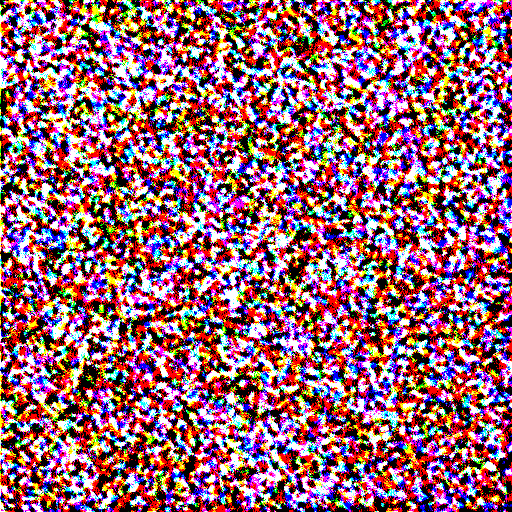


Batch 0, step 100, output 0:


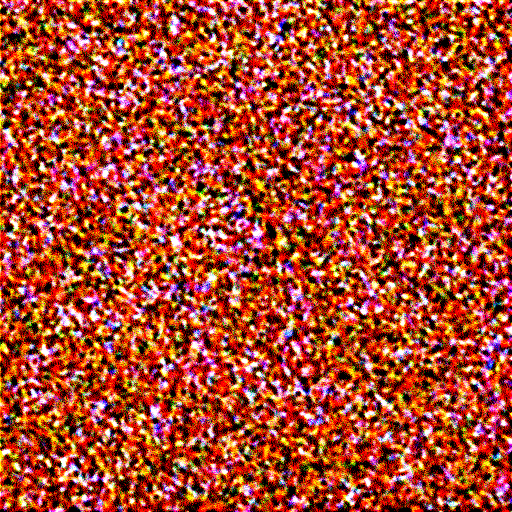


Batch 0, step 200, output 0:


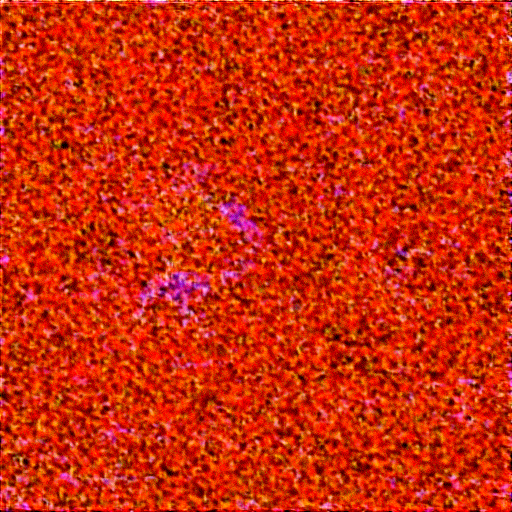


Batch 0, step 300, output 0:


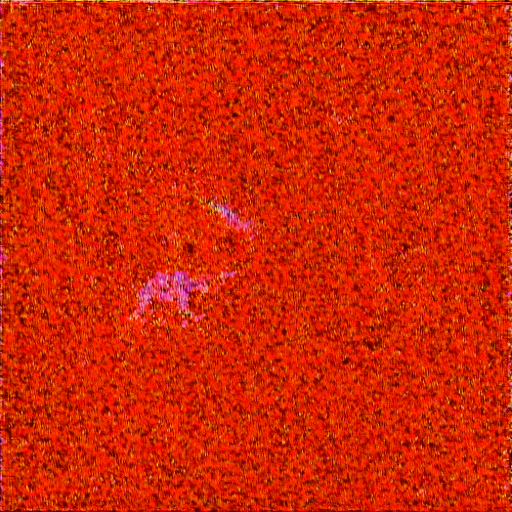


Batch 0, step 400, output 0:


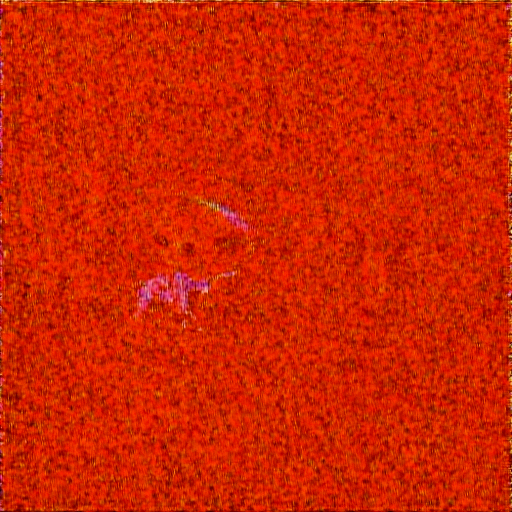


Batch 0, step 499, output 0:


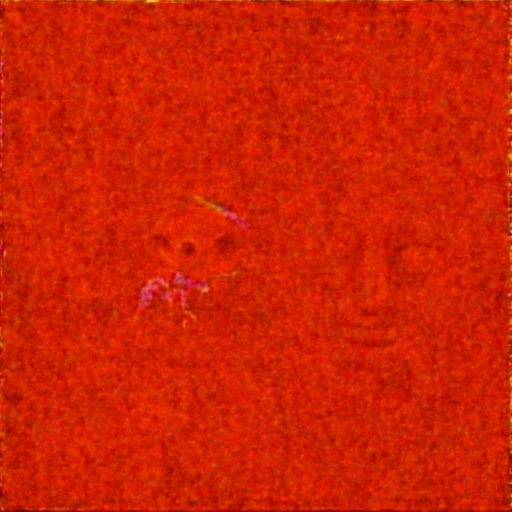

In [11]:
def do_run():
    if seed is not None:
        torch.manual_seed(seed)

    make_cutouts = MakeCutouts(clip_size, cutn, cut_pow)
    side_x = side_y = model_config['image_size']

    target_embeds, weights = [], []

    for prompt in prompts:
        txt, weight = parse_prompt(prompt)
        target_embeds.append(clip_model.encode_text(clip.tokenize(txt).to(device)).float())
        weights.append(weight)

    for prompt in image_prompts:
        path, weight = parse_prompt(prompt)
        img = Image.open(fetch(path)).convert('RGB')
        img = TF.resize(img, min(side_x, side_y, *img.size), transforms.InterpolationMode.LANCZOS)
        batch = make_cutouts(TF.to_tensor(img).unsqueeze(0).to(device))
        embed = clip_model.encode_image(normalize(batch)).float()
        target_embeds.append(embed)
        weights.extend([weight / cutn] * cutn)

    target_embeds = torch.cat(target_embeds)
    weights = torch.tensor(weights, device=device)
    if weights.sum().abs() < 1e-3:
        raise RuntimeError('The weights must not sum to 0.')
    weights /= weights.sum().abs()

    init = None
    if init_image is not None:
        init = Image.open(fetch(init_image)).convert('RGB')
        init = init.resize((side_x, side_y), Image.LANCZOS)
        init = TF.to_tensor(init).to(device).unsqueeze(0).mul(2).sub(1)

    cur_t = None

    def cond_fn(x, t, y=None):
        with torch.enable_grad():
            x = x.detach().requires_grad_()
            n = x.shape[0]
            alpha = torch.tensor(diffusion.sqrt_alphas_cumprod[cur_t], device=device, dtype=torch.float32)
            sigma = torch.tensor(diffusion.sqrt_one_minus_alphas_cumprod[cur_t], device=device, dtype=torch.float32)
            cosine_t = alpha_sigma_to_t(alpha, sigma)
            pred = secondary_model(x, cosine_t[None].repeat([n])).pred
            clip_in = normalize(make_cutouts(pred.add(1).div(2)))
            image_embeds = clip_model.encode_image(clip_in).float()
            dists = spherical_dist_loss(image_embeds.unsqueeze(1), target_embeds.unsqueeze(0))
            dists = dists.view([cutn, n, -1])
            clip_losses = dists.mul(weights).sum(2).mean(0)
            tv_losses = tv_loss(pred)
            range_losses = range_loss(pred)
            loss = clip_losses.sum() * clip_guidance_scale + tv_losses.sum() * tv_scale + range_losses.sum() * range_scale
            if init is not None and init_scale:
                init_losses = lpips_model(pred, init)
                loss = loss + init_losses.sum() * init_scale
            grad = -torch.autograd.grad(loss, x)[0]
            return grad

    if method == 'ddpm':
        sample_fn = diffusion.p_sample_loop_progressive
    elif method == 'ddim':
        sample_fn = diffusion.ddim_sample_loop_progressive
    elif method[:4] == 'plms':
        sample_fn = partial(diffusion.plms_sample_loop_progressive, order=int(method[4]))
    else:
        assert False

    for i in range(n_batches):
        cur_t = diffusion.num_timesteps - skip_timesteps - 1

        samples = sample_fn(
            model,
            (batch_size, 3, side_y, side_x),
            clip_denoised=False,
            model_kwargs={},
            cond_fn=cond_fn,
            progress=True,
            skip_timesteps=skip_timesteps,
            init_image=init,
            randomize_class=True,
        )

        for j, sample in enumerate(samples):
            if j % 100 == 0 or cur_t == 0:
                print()
                for k, image in enumerate(sample['pred_xstart']):
                    filename = f'progress_{i * batch_size + k:05}.png'
                    TF.to_pil_image(image.add(1).div(2).clamp(0, 1)).save(filename)
                    tqdm.write(f'Batch {i}, step {j}, output {k}:')
                    display.display(display.Image(filename))
            cur_t -= 1

gc.collect()
do_run()